In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

sys.path.append(os.path.abspath(".."))
from src.qst.models.mle import MLEQST

from scipy.linalg import sqrtm

def fidelity(rho1, rho2):
    sqrt_rho1 = sqrtm(rho1)
    F = np.trace(sqrtm(sqrt_rho1 @ rho2 @ sqrt_rho1))
    return np.real(F)**2



# Import Data (3 qubit example)

In [5]:
data_100 = np.load('../src/qst/datasets/3_qubit_shots/3q_100.npz', allow_pickle=True)

X_100 = data_100['counts']
y_100 = data_100['states']

rng = np.random.default_rng(42)
test_ind_pure = rng.choice(50_000, size=100, replace=False)
test_ind_mixed = rng.integers(50_000, 100_000, size=100)


# Test the MLE for a single State

In [6]:
mle = MLEQST(n_qubits=3)
rho_hat = mle.fit_single(X_100[0])
fidelity(rho_hat, y_100[0])

0.9718809785104977

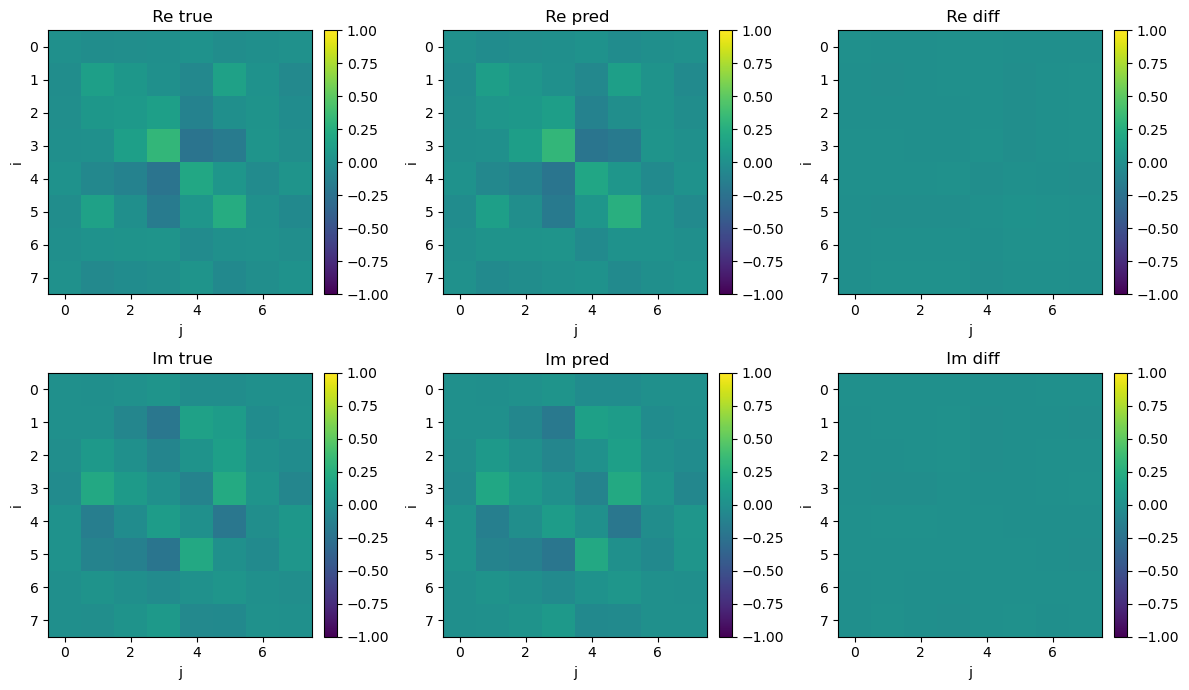

In [8]:
import numpy as np, matplotlib.pyplot as plt

def plot_rho_heatmaps(rho_true, rho_hat, title_prefix=""):
    def hm(ax, M, ttl):
        im = ax.imshow(M, vmin=-1, vmax=1, interpolation="nearest")
        ax.set_title(ttl); ax.set_xlabel("j"); ax.set_ylabel("i")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    fig, axs = plt.subplots(2, 3, figsize=(12, 7))
    hm(axs[0,0], np.real(rho_true), f"{title_prefix} Re true")
    hm(axs[1,0], np.imag(rho_true), f"{title_prefix} Im true")
    hm(axs[0,1], np.real(rho_hat),  f"{title_prefix} Re pred")
    hm(axs[1,1], np.imag(rho_hat),  f"{title_prefix} Im pred")
    hm(axs[0,2], np.real(rho_hat - rho_true), f"{title_prefix} Re diff")
    hm(axs[1,2], np.imag(rho_hat - rho_true), f"{title_prefix} Im diff")
    plt.tight_layout(); plt.show()

plot_rho_heatmaps(y_100[0], rho_hat)

In [9]:
rho_pred = mle.fit_batch(X_100[test_ind_pure])
mean_fid, std_fid, fids = mle.avg_fidelity(X_100[test_ind_pure], y_100[test_ind_pure])
print(mean_fid, std_fid)

0.9735704382565907 0.010496996626384588


In [13]:
data_ghz = np.load('../src/qst/datasets/Transfer_data/3q_noise_0.01_ghz.npz', allow_pickle=True)
X_ghz = data_ghz['counts']
y_ghz = data_ghz['states']
data_ghz_20 = np.load('../src/qst/datasets/Transfer_data/3q_noise_0.2_ghz.npz', allow_pickle=True)
X_ghz_20 = data_ghz_20['counts']
y_ghz_20 = data_ghz_20['states']

In [ ]:
mean_fid_ghz, std_fid_ghz, fids_ghz = mle.avg_fidelity(X_ghz[0:100], y_ghz[0:100])
print(mean_fid_ghz, std_fid_ghz)

0.9997838574416537 5.978547386434043e-05


## Load the Purity data


In [ ]:
data_p_10 = np.load('../src/qst/datasets/3_qubit_shots/3q_purity_10.npz', allow_pickle=True)
data_p_20 = np.load('../src/qst/datasets/3_qubit_shots/3q_purity_20.npz', allow_pickle=True)
data_p_50 = np.load('../src/qst/datasets/3_qubit_shots/3q_purity_50.npz', allow_pickle=True)
data_p_100 = np.load('../src/qst/datasets/3_qubit_shots/3q_purity_100.npz', allow_pickle=True)
data_p_1000 = np.load('../src/qst/datasets/3_qubit_shots/3q_purity_1000.npz', allow_pickle=True)
data_p_10_000 = np.load('../src/qst/datasets/3_qubit_shots/3q_purity_10000.npz', allow_pickle=True)
data_p_100_000 = np.load('../src/qst/datasets/3_qubit_shots/3q_purity_100000.npz', allow_pickle=True)

X_p_10 = data_p_10['counts']; y_p_10 = data_p_10['states']
X_p_20 = data_p_20['counts']; y_p_20 = data_p_20['states']
X_p_50 = data_p_50['counts']; y_p_50 = data_p_50['states']
X_p_100 = data_p_100['counts']; y_p_100 = data_p_100['states']
X_p_1000 = data_p_1000['counts']; y_p_1000 = data_p_1000['states']
X_p_10_000 = data_p_10_000['counts']; y_p_10_000 = data_p_10_000['states']
X_p_100_000 = data_p_100_000['counts']; y_p_100_000 = data_p_100_000['states']


def purity(rho: np.ndarray) -> float:
    return float(np.real_if_close(np.trace(rho @ rho)))

def fidelity(rho1: np.ndarray, rho2: np.ndarray) -> float:
    w, v = np.linalg.eigh((rho1 + rho1.conj().T)/2)
    w = np.clip(w, 0, None)
    sqrt_rho1 = (v * np.sqrt(w)) @ v.conj().T
    mid = (sqrt_rho1 @ rho2 @ sqrt_rho1 + (sqrt_rho1 @ rho2 @ sqrt_rho1).conj().T) / 2
    s, _ = np.linalg.eigh(mid)
    return float(np.sum(np.sqrt(np.clip(s, 0, None)))**2)

def fidelity_heatmap_by_purity_and_shots(
    datasets: dict[int, tuple[np.ndarray, np.ndarray]],
    reconstruct_mle,
    n_samples_per_ds: int = 100,
    n_purity_bins: int = 12,
    rng_seed: int = 0,
):

    rng = np.random.default_rng(rng_seed)
    shots_list = sorted(datasets.keys())

    any_Y = next(iter(datasets.values()))[1]
    d = any_Y.shape[1]
    Pmin_valid, Pmax_valid = 1.0/d, 1.0

    sampled = {}
    all_purities = []
    for sh in shots_list:
        X, Y = datasets[sh]
        N = len(X)
        idx = rng.choice(N, size=min(n_samples_per_ds, N), replace=False)
        sampled[sh] = (X[idx], Y[idx])

        # quick purity pass to set bin edges
        Ps = [purity(Yi) for Yi in Y[idx]]
        all_purities.extend(Ps)

    # Bin edges (clip to valid)
    Pmin_obs = max(min(all_purities), Pmin_valid)
    Pmax_obs = min(max(all_purities), Pmax_valid)
    edges = np.linspace(Pmin_obs, Pmax_obs, n_purity_bins + 1)
    centers = (edges[:-1] + edges[1:]) / 2

    # Heat matrix: rows = shots, cols = purity bins
    H = np.full((len(shots_list), n_purity_bins), np.nan, dtype=float)
    Ncell = np.zeros_like(H, dtype=int)

    # Compute fidelities per dataset/bin
    for r, sh in enumerate(shots_list):
        Xs, Ys = sampled[sh]
        Ps = np.array([purity(Yi) for Yi in Ys], dtype=float)

        # Bin assignment
        # rightmost bin inclusive of upper edge
        bin_idx = np.digitize(Ps, edges, right=False) - 1
        bin_idx = np.clip(bin_idx, 0, n_purity_bins - 1)

        # Compute mean fidelity per bin
        for c in range(n_purity_bins):
            sel = np.where(bin_idx == c)[0]
            if sel.size == 0:
                continue
            Fvals = np.empty(sel.size, dtype=float)
            for k, i in enumerate(sel):
                rho_hat = reconstruct_mle(Xs[i])
                Fvals[k] = fidelity(rho_hat, Ys[i])
            H[r, c] = np.mean(Fvals)
            Ncell[r, c] = sel.size

    return {
        "heat": H,
        "counts": Ncell,
        "shots": np.array(shots_list),
        "purity_edges": edges,
        "purity_centers": centers,
        "purity_range_obs": (Pmin_obs, Pmax_obs),
        "d": d,
    }

def plot_fidelity_heatmap(res, title="MLE Fidelity (mean) vs Purity and Shots"):
    H = res["heat"]
    shots = res["shots"]
    edges = res["purity_edges"]
    centers = res["purity_centers"]

    fig, ax = plt.subplots(figsize=(8, 4.6))
    im = ax.imshow(H, aspect="auto", origin="lower", vmin=0.0, vmax=1.0,
                   extent=[edges[0], edges[-1], -0.5, H.shape[0]-0.5])

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Mean fidelity $F(\\hat{\\rho},\\rho)$")

    ax.set_xlabel("Purity  Tr($\\rho^2$)")
    ax.set_ylabel("Number of shots")
    ax.set_title(title)

    ax.set_yticks(range(len(shots)))
    ax.set_yticklabels([f"{s:,}" for s in shots])

    ax.set_xlim(edges[0], edges[-1])
    ax.set_ylim(-0.5, H.shape[0]-0.5)
    ax.grid(False)
    plt.tight_layout()
    plt.show()

def plot_fidelity_lines(res, title="MLE Fidelity vs Purity (per shot count)", ylims=(0,1)):
    """
    Line plot version of the fidelity heatmap: one curve per shot count.
    Line plot including the standard error bars for each estimate
    """
    H = res["heat"]                     # (n_shots, n_bins)
    shots = res["shots"]                # array of shot counts
    purity = res["purity_centers"]      # x-axis

    plt.figure(figsize=(7.5, 4.5))
    for i, s in enumerate(shots):
        y = H[i]
        if np.all(np.isnan(y)):
            continue
        plt.plot(purity, y, marker='o', label=f"{s:,} shots")

    plt.xlabel("Purity  Tr($\\rho^2$)")
    plt.ylabel("Mean fidelity  $F(\\hat{\\rho},\\rho)$")
    plt.title(title)
    plt.ylim(ylims[0], ylims[1])
    plt.grid(alpha=0.3)
    plt.legend(title="Shots", fontsize=9)
    plt.tight_layout()
    plt.show()


datasets_3q = {
    10:(X_p_10, y_p_10),
    20:(X_p_20, y_p_20),
    50:(X_p_50, y_p_50),
    100:(X_p_100, y_p_100),
    1000:(X_p_1000, y_p_1000),
    10_000:(X_p_10_000, y_p_10_000)
}
mle_3q = MLEQST(n_qubits=3)

In [ ]:
data_2p_10 = np.load('../src/qst/datasets/2_qubit_shots/2q_purity_10.npz', allow_pickle=True)
data_2p_20 = np.load('../src/qst/datasets/2_qubit_shots/2q_purity_20.npz', allow_pickle=True)
data_2p_50 = np.load('../src/qst/datasets/2_qubit_shots/2q_purity_50.npz', allow_pickle=True)
data_2p_100 = np.load('../src/qst/datasets/2_qubit_shots/2q_purity_100.npz', allow_pickle=True)
data_2p_1000 = np.load('../src/qst/datasets/2_qubit_shots/2q_purity_1000.npz', allow_pickle=True)
data_2p_10_000 = np.load('../src/qst/datasets/2_qubit_shots/2q_purity_10000.npz', allow_pickle=True)

X_2p_10 = data_2p_10['counts']; y_2p_10 = data_2p_10['states']
X_2p_20 = data_2p_20['counts']; y_2p_20 = data_2p_20['states']
X_2p_50 = data_2p_50['counts']; y_2p_50 = data_2p_50['states']
X_2p_100 = data_2p_100['counts']; y_2p_100 = data_2p_100['states']
X_2p_1000 = data_2p_1000['counts']; y_2p_1000 = data_2p_1000['states']
X_2p_10_000 = data_2p_10_000['counts']; y_2p_10_000 = data_2p_10_000['states']



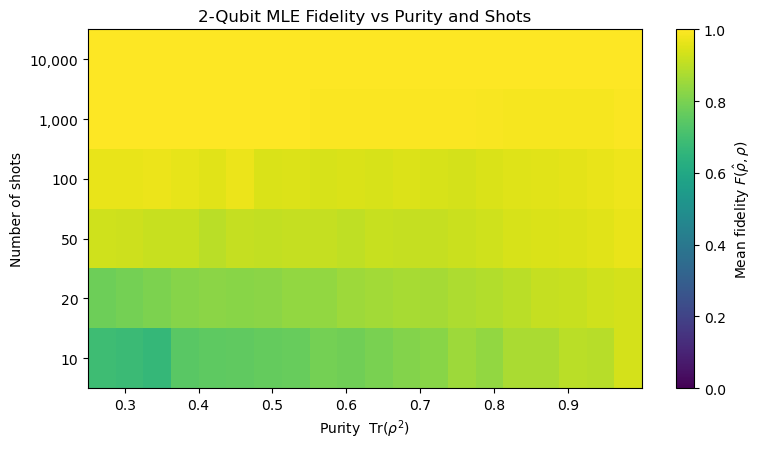

In [18]:
mle_2q = MLEQST(n_qubits=2)

datasets_2q = {
    10:(X_2p_10, y_2p_10),
    20:(X_2p_20, y_2p_20),
    50:(X_2p_50, y_2p_50),
    100:(X_2p_100, y_2p_100),
    1000:(X_2p_1000, y_2p_1000),
    10_000:(X_2p_10_000, y_2p_10_000)
}
res = fidelity_heatmap_by_purity_and_shots(
    datasets_2q,
    reconstruct_mle= mle_2q.fit_single,
    n_samples_per_ds=500,
    n_purity_bins=20,
    rng_seed=0,
)

plot_fidelity_heatmap(res, title="2-Qubit MLE Fidelity vs Purity and Shots")

In [27]:
res_3q = fidelity_heatmap_by_purity_and_shots(
    datasets_3q,
    reconstruct_mle=mle_3q.fit_single,
    n_samples_per_ds=400,
    n_purity_bins=20,
)



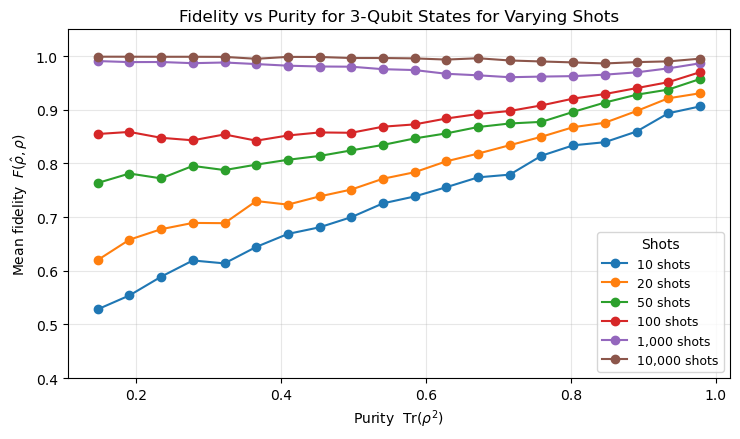

In [29]:
plot_fidelity_lines(res_3q, title="Fidelity vs Purity for 3-Qubit States for Varying Shots", ylims = (0.4,1.05))

In [31]:
res_2q = fidelity_heatmap_by_purity_and_shots(
    datasets_2q,
    reconstruct_mle=mle_2q.fit_single,
    n_samples_per_ds=400,
    n_purity_bins=20,
)


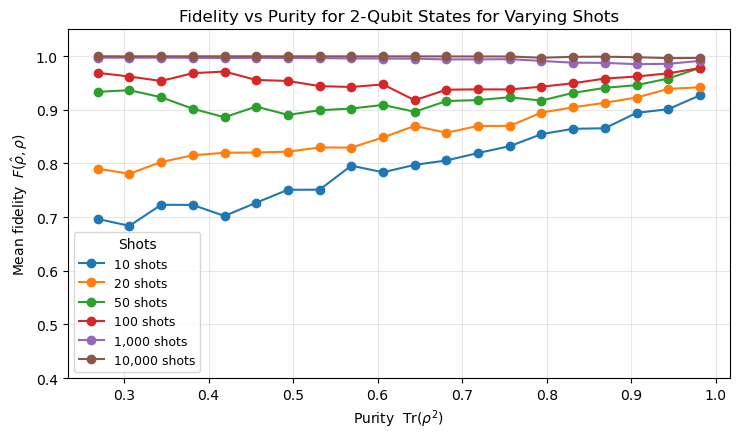

In [ ]:
plot_fidelity_lines(res_2q, title="Fidelity vs Purity for 2-Qubit States for Varying Shots", ylims = (0.4,1.05))


In [ ]:

def _tqdm(x, **kwargs): return x

def _eigvals_psd(rho: np.ndarray) -> np.ndarray:
    """
    Hermitian-eigvals with tiny-negative clipping and trace renormalization.
    """
    # symmetrize for safety
    rhoH = 0.5 * (rho + rho.conj().T)
    w = np.linalg.eigvalsh(rhoH)
    w = np.clip(np.real(w), 0.0, None)
    s = w.sum()
    if s > 0:
        w = w / s
    else:
        w = np.ones_like(w) / w.size
    return w

def mle_eigvals_by_purity(
    datasets: dict[int, tuple[np.ndarray, np.ndarray]],
    reconstruct_mle,
    shots: int | None = None,
    n_samples_per_bin: int = 60,
    n_purity_bins: int = 3,
    rng_seed: int = 0,
    purity_edges: np.ndarray | None = None,
):
    
    rng = np.random.default_rng(rng_seed)

    # choose shots bucket
    if shots is None:
        shots = max(datasets.keys())
    X, Y = datasets[shots]
    N = len(X)
    d = Y.shape[1]
    pmin_valid, pmax_valid = 1.0 / d, 1.0

    # true purities
    def _purity(rho): return float(np.real(np.trace(rho @ rho)))
    Ps = np.array([_purity(Y[i]) for i in range(N)], dtype=float)

    # bin edges: use observed range clipped to valid unless provided
    if purity_edges is None:
        Pmin_obs = max(Ps.min(), pmin_valid)
        Pmax_obs = min(Ps.max(), pmax_valid)
        edges = np.linspace(Pmin_obs, Pmax_obs, n_purity_bins + 1)
    else:
        edges = np.asarray(purity_edges, dtype=float)
        assert np.all(np.diff(edges) > 0), "purity_edges must be strictly increasing"

    centers = 0.5 * (edges[:-1] + edges[1:])
    # rightmost bin inclusive (match your style)
    bin_idx = np.digitize(Ps, edges, right=False) - 1
    bin_idx = np.clip(bin_idx, 0, len(edges) - 2)

    bin_labels = [
        f"[{edges[j]:.3f}, {edges[j+1]:.3f})" if j < len(edges)-2 else f"[{edges[j]:.3f}, {edges[j+1]:.3f}]"
        for j in range(len(edges)-1)
    ]

    eigvals_by_bin: list[list[float]] = [[] for _ in range(len(edges)-1)]
    n_states_used = np.zeros(len(edges)-1, dtype=int)

    # for each bin, randomly pick up to n_samples_per_bin states, reconstruct MLE, collect eigvals
    for b in range(len(edges) - 1):
        idxs = np.flatnonzero(bin_idx == b)
        if idxs.size == 0:
            continue
        take = min(n_samples_per_bin, idxs.size)
        pick = rng.choice(idxs, size=take, replace=False)
        n_states_used[b] = take

        for i in _tqdm(pick, desc=f"MLE eigvals | shots={shots} | purity {bin_labels[b]}"):
            rho_hat = reconstruct_mle(X[i])   # <-- your MLE routine
            w = _eigvals_psd(rho_hat)
            eigvals_by_bin[b].extend(w.tolist())

    return {
        "shots": shots,
        "d": d,
        "purity_edges": edges,
        "purity_centers": centers,
        "bin_labels": bin_labels,
        "eigvals_by_bin": eigvals_by_bin,
        "n_states_used_per_bin": n_states_used,
    }

def plot_mle_eigval_histograms(
    res: dict,
    n_bins_hist: int = 25,
    sharey: bool = True,
    title: str | None = None,
):
    """
    Plot histograms of MLE eigenvalues per purity bin (subplots across bins).
    """
    edges = res["purity_edges"]
    labels = res["bin_labels"]
    eigvals_by_bin = res["eigvals_by_bin"]
    shots = res["shots"]

    nb = len(labels)
    fig, axes = plt.subplots(1, nb, figsize=(4.6 * nb, 3.8), sharey=sharey)
    if nb == 1:
        axes = [axes]

    for ax, lab, vals in zip(axes, labels, eigvals_by_bin):
        vals = np.asarray(vals, dtype=float)
        if vals.size == 0:
            ax.set_visible(False)
            continue
        ax.hist(vals, bins=n_bins_hist, density=True, alpha=0.9)
        ax.set_xlabel("Eigenvalue")
        ax.set_title(f"Purity {lab}\n(n eigvals = {vals.size})")
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Density")
    if title is None:
        title = f"MLE eigenvalue histograms by purity bands (shots={shots:,})"
    fig.suptitle(title)
    plt.ylim(0, 25)
    fig.tight_layout()
    plt.show()


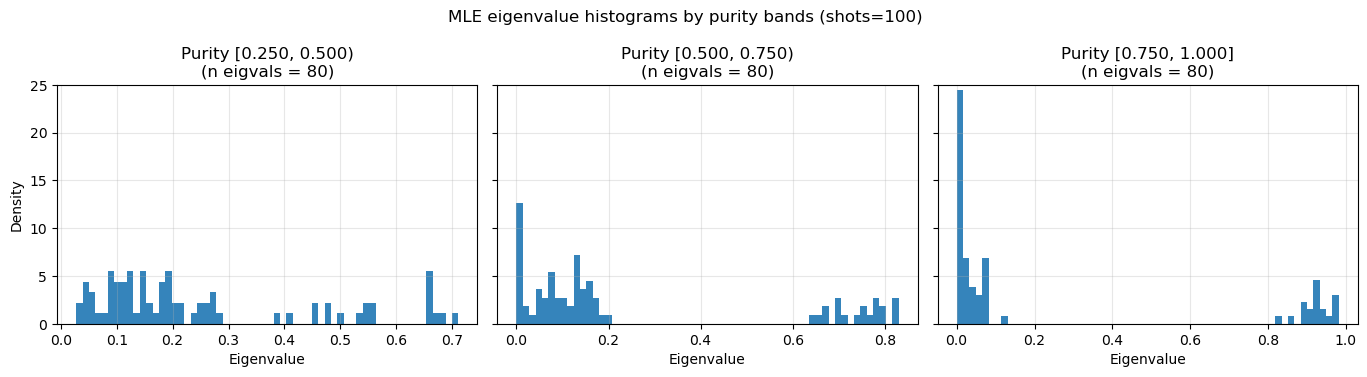

In [64]:
res_eigs_2q = mle_eigvals_by_purity(
    datasets_2q,
    reconstruct_mle=mle_2q.fit_single,
    shots=100,
    n_samples_per_bin=20,
    n_purity_bins=3,
    rng_seed=123)

plot_mle_eigval_histograms(res_eigs_2q, n_bins_hist=60)

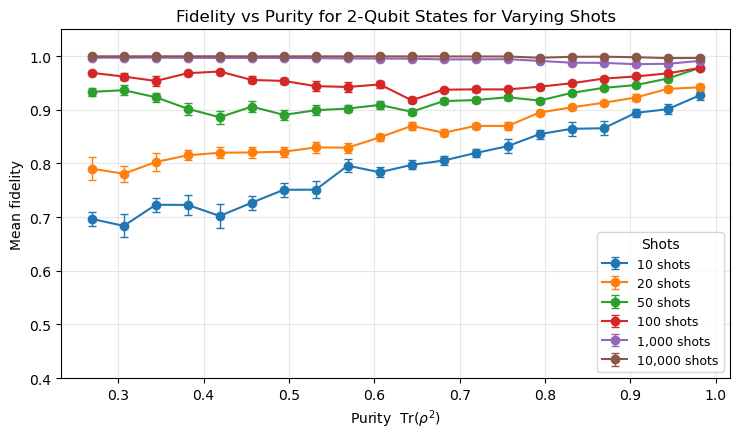

In [ ]:


res_2q = fidelity_heatmap_by_purity_and_shots(
    datasets_2q,
    reconstruct_mle=mle_2q.fit_single,
    n_samples_per_ds=400,
    n_purity_bins=20,
)
plot_fidelity_lines(res_2q, title="Fidelity vs Purity for 2-Qubit States for Varying Shots", ylims = (0.4,1.05))

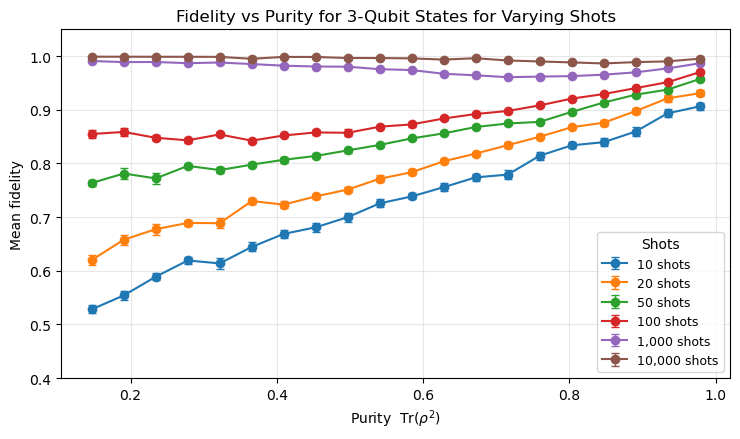

In [56]:

res_3q = fidelity_heatmap_by_purity_and_shots(
    datasets_3q,
    reconstruct_mle=mle_3q.fit_single,
    n_samples_per_ds=400,
    n_purity_bins=20,
)
plot_fidelity_lines(res_3q, title="Fidelity vs Purity for 3-Qubit States for Varying Shots", ylims = (0.4,1.05))

In [ ]:
def fidelity_heatmap_by_purity_and_shots(
    datasets: dict[int, tuple[np.ndarray, np.ndarray]],
    reconstruct_mle,
    n_samples_per_ds: int = 100,
    n_purity_bins: int = 12,
    rng_seed: int = 0,
):
    rng = np.random.default_rng(rng_seed)
    shots_list = sorted(datasets.keys())

    any_Y = next(iter(datasets.values()))[1]
    d = any_Y.shape[1]
    Pmin_valid, Pmax_valid = 1.0/d, 1.0

    sampled = {}
    all_purities = []
    for sh in shots_list:
        X, Y = datasets[sh]
        N = len(X)
        idx = rng.choice(N, size=min(n_samples_per_ds, N), replace=False)
        sampled[sh] = (X[idx], Y[idx])
        Ps = [purity(Yi) for Yi in Y[idx]]
        all_purities.extend(Ps)

    Pmin_obs = max(min(all_purities), Pmin_valid)
    Pmax_obs = min(max(all_purities), Pmax_valid)
    edges = np.linspace(Pmin_obs, Pmax_obs, n_purity_bins + 1)
    centers = (edges[:-1] + edges[1:]) / 2

    H = np.full((len(shots_list), n_purity_bins), np.nan, dtype=float)   # mean fidelity
    SE = np.full_like(H, np.nan, dtype=float)                            # standard error
    Ncell = np.zeros_like(H, dtype=int)

    for r, sh in enumerate(shots_list):
        Xs, Ys = sampled[sh]
        Ps = np.array([purity(Yi) for Yi in Ys], dtype=float)
        bin_idx = np.digitize(Ps, edges, right=False) - 1
        bin_idx = np.clip(bin_idx, 0, n_purity_bins - 1)

        for c in range(n_purity_bins):
            sel = np.where(bin_idx == c)[0]
            n = sel.size
            if n == 0:
                continue
            Fvals = np.empty(n, dtype=float)
            for k, i in enumerate(sel):
                rho_hat = reconstruct_mle(Xs[i])
                Fvals[k] = fidelity(rho_hat, Ys[i])

            mean = float(np.mean(Fvals))
            if n > 1:
                std = float(np.std(Fvals, ddof=1))
                se = std / np.sqrt(n)
            else:
                se = np.nan  # not enough samples to estimate variance

            H[r, c] = mean
            SE[r, c] = se
            Ncell[r, c] = n

    return {
        "heat": H,
        "stderr": SE,
        "counts": Ncell,
        "shots": np.array(shots_list),
        "purity_edges": edges,
        "purity_centers": centers,
        "purity_range_obs": (Pmin_obs, Pmax_obs),
        "d": d,
    }
def plot_fidelity_lines(res, title="MLE Fidelity vs Purity (per shot count)", ylims=(0,1)):
    H = res["heat"]
    E = res["stderr"] 
    shots = res["shots"]
    purity = res["purity_centers"]

    plt.figure(figsize=(7.5, 4.5))
    for i, s in enumerate(shots):
        y = H[i]
        e = E[i]
        if np.all(np.isnan(y)):
            continue
        plt.errorbar(
            purity, y, yerr=e, fmt='-o', capsize=3, elinewidth=1, linewidth=1.5,
            label=f"{s:,} shots"
        )

    plt.xlabel("Purity  Tr($\\rho^2$)")
    plt.ylabel("Mean fidelity")
    plt.title(title)
    plt.ylim(ylims[0], ylims[1])
    plt.grid(alpha=0.3)
    plt.legend(title="Shots", fontsize=9)
    plt.tight_layout()
    plt.show()